In [23]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

In [24]:
def project_theta(theta, m_values):
    projections = []
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        projections.append(projected_vectors)
    return torch.stack(projections, axis=0)

def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    return evaluated_function

In [25]:
from scipy.ndimage import gaussian_filter
def mask_and_blur_images(array):
    '''masks signal inside radius of 14 and outside radius of 30 and adds gaussian blur for all intensity data'''
    for i in range(0,60):
        x,y = np.meshgrid(np.arange(128), np.arange(128))
        radius = np.sqrt((x-64)**2 + (y-62)**2)
        mask1 = radius <= 14
        mask2 = radius >= 30
        masked_data = array[i].copy()
        masked_data[mask1] = 0
        masked_data2 = masked_data.copy()
        masked_data2[mask2] = 0
        # masked_data_norm = (masked_data - np.min(masked_data) / (np.max(masked_data) - np.min(masked_data)))
        blurred_data = gaussian_filter(masked_data2, sigma=.65)
        array[i] = blurred_data
    return array

### Note, I think the columns and rows are showing x vs y respectively (opposite how we normally plot)
#### We can double check this later

## Load data and optimize offset

In [26]:
# Define parameters
ms = torch.arange(12)
angles = torch.arange(0, 6) * 2 * torch.pi / 6.

# Extract data_theta
data = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/images/image_111019.npz')['data']
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))

# Extract data file paths
file_path = '/Users/cadenmyers/billingelab/dev/skyrmion_lattices/tests/'
files = ['118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121855.npz', '122365.npz', '122875.npz']

# Extract Training data (can ignore)
# Extract data intensity and phi (unmasked)
# training_data = np.load('/Users/yucongchen/billingegroup/skyrmion-lattices-data/training_data.npz')
# data_intensity = torch.tensor(training_data['intensity'])
# data_intensity = torch.tensor(mask_and_blur_images(training_data['intensity']))
# Preprocess phi to get angle difference
# phi = training_data['phi'] - 253.1473
# print("phi:", phi)

In [27]:
# Made offset a required argument
def optimize_offset(intensity, offset):
    max_iter = 101    
    opt = torch.optim.Adam([offset], lr=1e-2)
    for i in range(max_iter):
        projection = project_theta(angles + offset, ms).sum(1)
        evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
        loss = -(intensity * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        #if i % 100 == 0:
        #    print(loss.item(), offset.item())
    return offset, evaluate_image_theta

In [28]:
# Training/Testing
for file in files:
    # Read in data intensity
    data = np.load(file_path + file)
    data_intensity = torch.tensor(mask_and_blur_images(data['intensity']))
    data_numor = data['numor']
    print(data_numor)
    
    # Iterate to find offset
    offset_list, evaluate_image_theta_list = [], []
    offset = torch.tensor(0.)
    offset.requires_grad = True
    for intensity in data_intensity:
        offset, evaluate_image_theta = optimize_offset(intensity, offset)
        offset_list.append(offset.item()), evaluate_image_theta_list.append(evaluate_image_theta)
    print("offset in radius:", offset_list)

    # Plot
    fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(30, 18))
    for i in range(6):
        for j in range(10):
            ax[i, j].imshow((evaluate_image_theta_list[i*6 + j] / evaluate_image_theta_list[i*6 + j].abs().max() + data_intensity[i*6 + j] / data_intensity[i*6 + j].abs().max()).detach(), cmap='plasma')
    fig.suptitle(file)
    plt.show()

    # Results
    offset_diff_degrees = []
    for offset in offset_list:
        # We're plotting y vs x instead of x vs y hence we need to use 90-offset instead of offset
        new_offset = -offset/torch.pi*180
        offset_diff_degrees.append(new_offset)
    print("offset (preprocessed) in degrees:", offset_diff_degrees)
    
    # Save offset and evaluate image theta
    np.savez('offset_' + file, numor=data['numor'], offset=offset_list)



[118923 118924 118925 118926 118927 118928 118929 118930 118931 118932
 118933 118934 118935 118936 118937 118938 118939 118940 118941 118942
 118943 118944 118945 118946 118947 118948 118949 118950 118951 118952
 118953 118954 118955 118956 118957 118958 118959 118960 118961 118962
 118963 118964 118965 118966 118967 118968 118969 118970 118971 118972
 118973 118974 118975 118976 118977 118978 118979 118980 118981 118982]


KeyboardInterrupt: 

Angles in degrees (starting numor = 118923 ): [0.0, -2.508262321734829, -0.05561823041141167, -0.004598424858709649, -1.298459942354441, -2.19275710095172, -4.188102951869858, -1.5968828600233458, -0.16836416304081325, -1.7092906982888323, -1.3015881689943072, -0.2784224162318125, 1.2194175781844727, -0.615174647975536, -2.3148808833115524, -0.24625905543022242, -2.08105277217075, -2.994278092505425, -3.2581231775011403, -1.3838099862229214, -3.8000850277633127, -4.173348035715339, -1.1397912328404622, -2.1767847035776455, -1.0984327298687404, -2.8654060832456274, -2.6228592356292992, -1.94935135704727, -1.7018560373772722, -0.8988426494899215, -1.1292471283092524, 1.423877583441513, 0.542276038963994, 0.15762881321284894, 0.5379747273341771, -0.706408899813983, -0.16829586114911166, -0.2507686878297264, -3.003630329026464, -3.665962310579065, -2.7123517892293947, -0.9582806631946639, -1.3179686701712932, -0.6959313896271837, -0.31273387152737087, -0.9982628830486284, -1.76037539063865

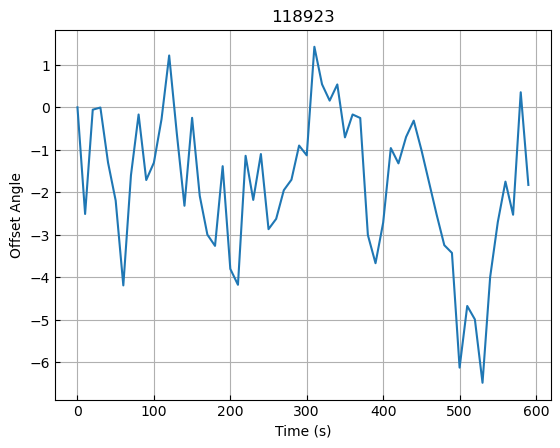

Angles in degrees (starting numor = 119486 ): [0.0, -0.5818672304879726, -1.9733680097163315, -4.0502150929056455, -4.613405171108216, -5.192659854238656, -6.459195492412462, -6.958610386787331, -7.799519371737208, -7.751576566405596, -8.907688536267806, -7.433426354866402, -9.251926655341858, -9.668660402266433, -11.706969850611241, -12.314252215000831, -13.538003548213677, -14.890524437848772, -16.959221397810975, -17.875194161739284, -19.592016851135345, -20.67748417441212, -21.05781642815511, -20.905492964380063, -24.004482979503667, -27.230043230136776, -24.005087451245213, -20.563133147327765, -44.116179896281324, -54.10614434993619, -55.145371292531976, -56.88292360605904, -58.078527729702245, -61.56094065916828, -61.16724172521957, -62.612154583757416, -62.187781270246205, -60.51661839545166, -58.2963561227123, -57.54873044635187, -58.13577154513612, -59.57033666708142, -60.22802924264029, -60.43430778576385, -62.187528553246906, -64.46669437738846, -66.79227816712942, -67.7409

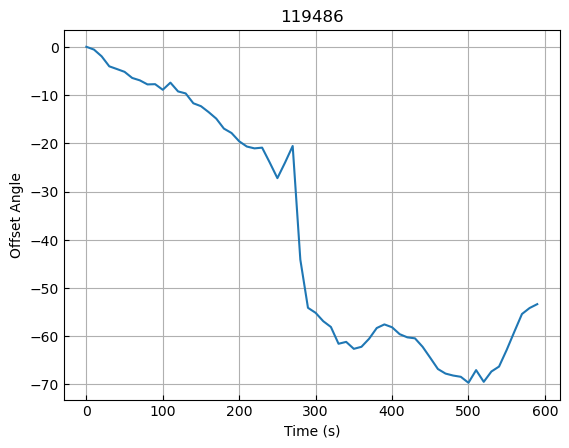

Angles in degrees (starting numor = 119996 ): [0.0, 0.5519868604164593, 0.07582022242901942, -0.47877747779768143, -1.5991624356588403, -3.786902762665189, -0.031912351349589585, 4.831762903778934, 1.9107778637096224, 0.6363636023282062, -0.9031524988562012, -3.498462166468258, -3.739605410210146, -0.4942888374027774, -1.9547472064915787, -1.5285946287015584, -2.257881247140503, -1.650093448752333, 0.5173748767974153, -2.7365118758710274, -2.429807353833482, -5.185728919778384, -9.738418831807067, -9.95130046031073, -13.478056685415767, -2.3256111104976434, -14.033644763072116, -27.01605852608215, -40.912432708536286, -43.89737137112537, -44.54171434195145, -43.8189659220955, -44.0937478474997, -44.6212399420052, -45.11549292091483, -46.65401010693313, -44.931871822815495, -45.2196362302846, -47.21445615663664, -49.151511465630605, -49.63555843437294, -49.40676588019773, -49.48296517812569, -51.67342733551629, -53.27106663899022, -53.68213132890368, -54.78452215339644, -55.956956567827

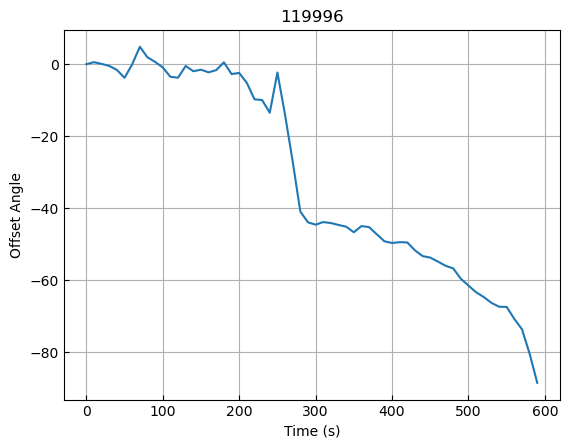

Angles in degrees (starting numor = 120506 ): [0.0, 10.030377829200201, 12.34619103333346, 9.689685432079028, 0.36832648872940155, -7.840968374715427, -34.98476851374974, -46.66547799454956, -48.09421696513283, -54.39645983306028, -63.06552034274806, -71.13465118668776, -48.85981969938874, -44.465480893077626, -44.89512711262812, -57.526120812651826, -66.68437313107425, -73.13509748136862, -71.55594408488332, -62.74270511200575, -54.447870666942976, -59.74386274558745, -63.700174690236466, -59.13826402282828, -50.765524440092335, -47.502203488632816, -52.2672644725247, -71.45202958685076, -45.122627053502896, -40.49921053261873, -48.099947493846486, -56.85822393447296, -67.78038626642953, -72.23793164331993, -71.4363679630839, -61.80428493137018, -56.461492396532776, -59.792377579262066, -64.11492426720716, -49.59470707294709, -47.965836729493276, -44.89117926328785, -54.73380970635638, -66.92243254440588, -71.05056472781574, -48.087598511827096, -40.83244180184532, -48.313343094085184

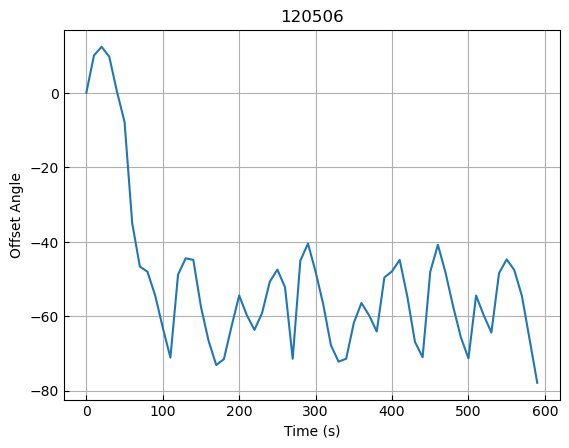

Angles in degrees (starting numor = 121016 ): [0.0, -9.066336755214275, -7.942751853726962, -4.740764293466858, -4.219465472991269, -14.851363548242505, -9.053518197689451, -0.08687829869526986, -11.702757331440635, -10.614718441941362, -4.2173959256727525, -6.7366616821604755, -19.422491555935636, -3.3216661348970664, -1.102580362242234, -12.431789525332997, -1.5633124802527352, -6.836906661061461, -7.805615315571442, -15.921159002468675, -2.4294009575778635, -5.019598228596168, -8.777544404275089, -1.4042715254289906, -2.302895608865475, -10.67877707861962, -6.658915346385511, 2.802190974929866, -5.412936870066153, -19.703277217620276, -1.1484792334647178, -3.3576680620122, -12.06435779138487, -4.16426729921381, -2.9451451267109423, -4.365370266493789, -18.29621385236804, -0.7233716746177112, -2.15114246588613, -12.83454529012114, 4.345703590552381, -0.16273437961743298, -6.367921966986289, -12.876209444058217, -5.138061029560868, -0.8628697506787599, -10.385893444367595, 5.241503390

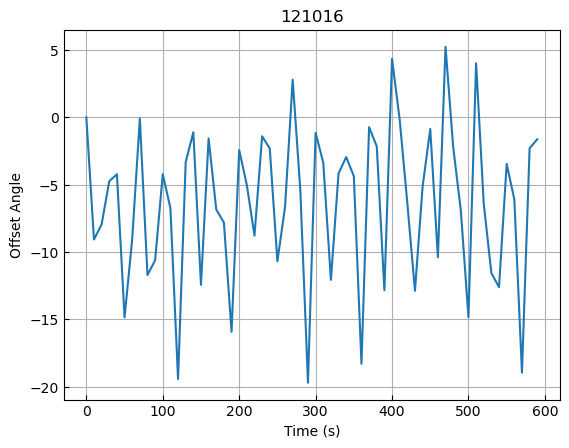

Angles in degrees (starting numor = 121405 ): [0.0, 26.8445759547984, 10.173285877204373, 6.34902966374203, 31.139692176149904, 26.113017871573604, 21.382205377170866, 13.402340623371588, -9.408421657152488, 11.53860910266501, -7.262967031297688, -20.239704907107445, -41.15906144795534, -59.66235126803254, -64.41993319478325, -91.48158664866983, -79.65220444020632, -80.17275364742049, -67.36929084066479, -75.62948939644644, -49.29914429699315, -56.318946348554604, -34.56111237010136, -45.55279919761948, -53.886606702086354, -73.7418095249625, -46.959647411912854, -73.48316392147247, -83.9693347881396, -98.42247952475014, -112.63421805533575, -112.61688303522227, -88.33556053582694, -84.09421113673494, -100.43420246175067, -112.10226926239683, -130.30708664593362, -123.639087147952, -134.48710777646806, -120.82610105903892, -117.72262702472521, -130.73763445045455, -160.24253536291388, -171.59993783935118, -199.2073575588676, -212.84855672770368, -236.14556700543017, -214.20074293806948

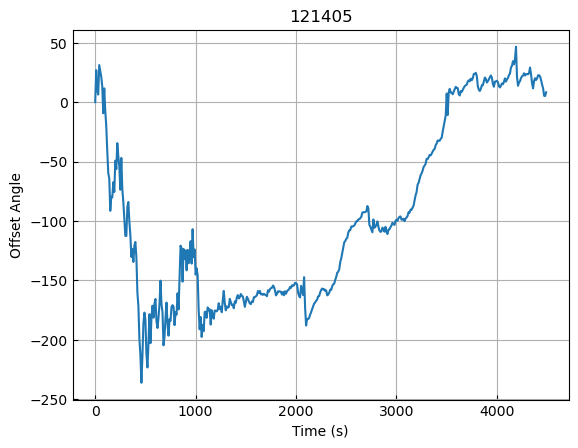

Angles in degrees (starting numor = 121855 ): [0.0, 0.08867463844698342, 0.4270353797402464, 1.8842417250104795, 3.3525590805130303, 4.8814508224434885, 6.826827863167459, 8.566552176850575, 9.456454535603775, 11.290676650888136, 13.138205682222972, 11.983086224224532, 13.150430226733414, 14.110629959641443, 13.514590513512518, 14.301212407887192, 14.47106907398336, 15.226125249108819, 18.046284210589167, 19.488673527672116, 22.173455685203578, 24.99805010749791, 28.215105918840706, 32.08978600385066, 35.74856978561205, 41.25864902114871, 45.511217005952446, 47.62277340295647, 50.275396895441396, 53.43228300906461, 54.97251798765917, 57.31279351430482, 59.54120420272401, 61.79593844020443, 62.152826069621355, 65.34760265766522, 68.199285183321, 70.94019228592292, 71.38213284597941, 75.85714643167213, 76.78450853604144, 76.68841460460854, 76.38082386552618, 75.90219835943753, 77.69944652631051, 75.75846385854379, 79.37472800517455, 80.93309030582631, 85.33783832043252, 87.8503712179459,

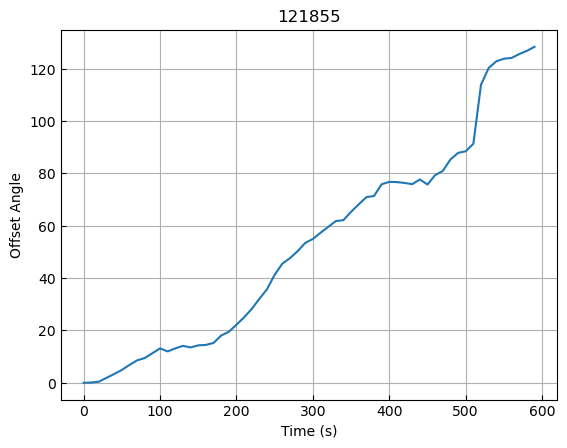

Angles in degrees (starting numor = 122365 ): [0.0, 7.700800940115719, 9.354003832487699, 12.517269342795705, 15.466335851863878, 19.655959374597714, 24.268493696586752, 28.430100637118844, 32.30923656678859, 35.32259308519316, 39.220254195439274, 42.17806078532413, 43.29532605428189, 45.09202097583208, 47.710329597926865, 49.943637531980954, 49.64897292590285, 50.517673950585504, 47.39311512230396, 47.45257533412351, 45.77668596842333, 46.11446614363714, 41.869776782041015, 49.290896843570344, 49.55089823961063, 54.345284640703966, 56.816450497509166, 60.27174074578107, 60.91125818795853, 61.51478394830462, 57.33230736476356, 54.661286757749195, 52.966559730318124, 53.5790842648957, 52.97484474978135, 57.35481625317333, 62.08750897058852, 68.68929661475605, 75.26755425723289, 81.39246492373928, 85.86478399980442, 86.63310514934999, 89.5985478907269, 92.34341650304744, 92.61823599449208, 89.23925944981673, 93.71679679040777, 99.43591908813453, 111.7682012949969, 119.08965182106283, 118

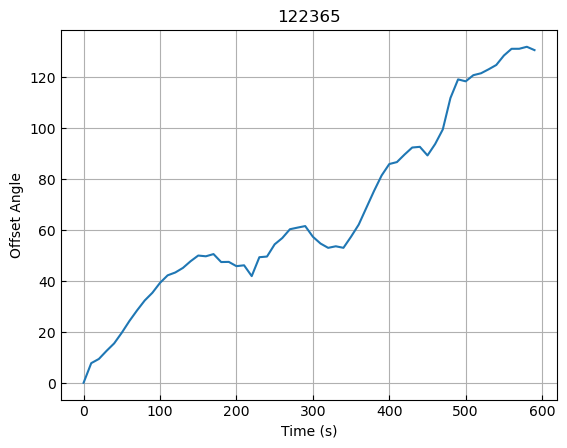

Angles in degrees (starting numor = 122875 ): [0.0, 8.735149420096814, 18.44032230611884, 24.111295185291613, 44.208962893514055, 51.758575888804245, 62.47406352666539, 69.03768407375088, 79.55454298035889, 59.516830672670835, 44.51113729258459, 52.479386242483216, 59.60233098070104, 71.01027002680725, 83.71875905315392, 100.53618060115355, 106.0019575221862, 114.00875605976039, 128.6692380188158, 135.45126069480165, 145.6097054247132, 163.17361883767106, 171.58184125314523, 182.6867179755888, 191.70180269881857, 198.76619905547108, 215.1359631750789, 228.2983387623404, 238.63118554251906, 246.61931034290245, 253.29349799227214, 269.3538682028567, 269.553145802081, 287.1448717453391, 297.1015936683035, 303.0285313017171, 309.19867831109656, 334.8095927550832, 343.1969011313188, 355.6144036084554, 366.6232751919253, 375.4030735586265, 383.76582057460666, 391.4839343367211, 407.7283098435458, 420.0331141993772, 429.3028556956218, 435.5343651245046, 449.96144585924236, 461.59746541230277,

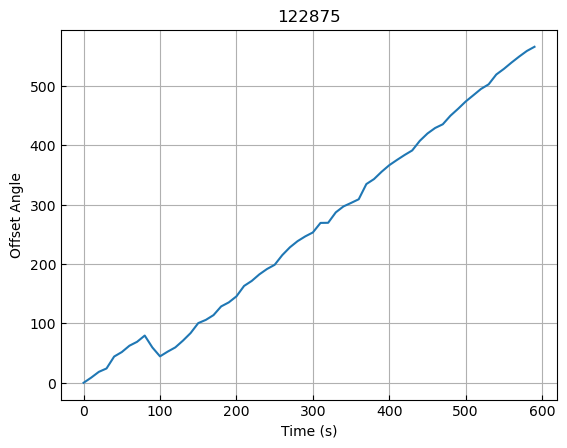

In [30]:
# offset
for file in files:
    # Read in data intensity
    data = np.load(file_path + 'offset_' + file)
    data_numor = data['numor']
    data_offset = data['offset']
    
    # Preprocess offset
    # Results
    offset0 = -data_offset[0]/torch.pi*180
    offset_diff_degrees = []
    for offset in data_offset:
        # We're plotting y vs x instead of x vs y hence we need to use 90-offset instead of offset
        new_offset = -offset/torch.pi*180 - offset0
        offset_diff_degrees.append(new_offset)
    print("Angles in degrees (starting numor =", data_numor[0], "):", offset_diff_degrees)
    time = np.arange(len(offset_diff_degrees)) * 10
    # np.savez(f"{file.removesuffix(".npz")}_offset.npz", time=time, offset_angle=offset_diff_degrees)

    # Plot angles
    plt.plot(time, offset_diff_degrees)
    plt.ylabel("Offset Angle")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.title(data['numor'][0])
    plt.tick_params(direction='in')
    # plt.ylim(-30,30)
    plt.show()
